In [70]:
import re
from typing import List, Union, Tuple
from nltk.corpus import stopwords as stpwrds
from sklearn.model_selection import train_test_split
import time
from os.path import isfile
import numpy as np
# Webscraping
from bs4 import BeautifulSoup
from requests import get
import seaborn as sns
import pandas as pd
import nltk
import unicodedata
import nltk.sentiment
from importlib import reload

import os

import matplotlib.pyplot as plt
import json
from typing import Dict, List, Optional, Union, cast
import requests
import prepare as p
import explore as e
from nltk.tokenize.toktok import ToktokTokenizer
import matplotlib
from scipy import stats
import acquire as w

In [49]:
df = w.get_michelin_pages()

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6780 entries, 0 to 6779
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   name                     6780 non-null   object 
 1   address                  6780 non-null   object 
 2   location                 6780 non-null   object 
 3   price                    6726 non-null   object 
 4   cuisine                  6780 non-null   object 
 5   longitude                6780 non-null   float64
 6   latitude                 6780 non-null   float64
 7   phone_number             6649 non-null   float64
 8   url                      6780 non-null   object 
 9   website_url              5542 non-null   object 
 10  award                    6780 non-null   object 
 11  facilities_and_services  6732 non-null   object 
 12  data                     6780 non-null   object 
dtypes: float64(3), object(10)
memory usage: 688.7+ KB


In [51]:
reload(p)
train, validate, test= p.prepare_michelin(df)

In [75]:
train.head()

,name,address,location,price,cuisine,longitude,latitude,url,award,facilities_and_services,data,price_level,city,country,clean,lemmatized,sentiment,word_count
6345,gasthaus ödenturm,"am ödenturm 11, cham, 93413, germany","cham, germany",€,"country cooking, mediterranean cuisine",12.703851,49.210919,https://guide.michelin.com/en/bayern/cham/rest...,bib gourmand,"car park,credit card / debit card accepted,gre...","as if straight out of a picture book, this bea...",1,cham,germany,straight picture book beautiful inn stands edg...,straight picture book beautiful inn stand edge...,0.9136,38
6427,weinhaus anker,"obertorstraße 13, marktheidenfeld, 97828, germany","marktheidenfeld, germany",€,"french, country cooking",9.600301,49.845621,https://guide.michelin.com/en/bayern/marktheid...,bib gourmand,"american express credit card,car park,credit c...",a restaurant that is steeped in tradition and ...,1,marktheidenfeld,germany,steeped tradition run great commitment lovely ...,steeped tradition run great commitment lovely ...,0.9186,35
5217,yang bao bao (nanzih),"106 chaoming road, nanzih district, kaohsiung,...","kaohsiung, taipei & taichung",$,dumplings,120.328050,22.724160,https://guide.michelin.com/en/kaohsiung-region...,bib gourmand,"air conditioning,car park,cash only","in 1993, this dumpling shop began life as a st...",1,kaohsiung,taipei & taichung,1993 dumpling shop began life street stall loc...,1993 dumpling shop began life street stall loc...,0.6808,49
3858,le bistrot gastronómico,"temprado 12, castelló de la plana, 12002, spain","castelló de la plana, spain",€€,fusion,-0.037028,39.983588,https://guide.michelin.com/en/comunidad-valenc...,bib gourmand,"air conditioning,american express credit card,...","an unpretentious, friendly and informal restau...",2,castelló de la plana,spain,unpretentious friendly informal whose aim prov...,unpretentious friendly informal whose aim prov...,0.9607,49
124,fat duck,"high street, bray, sl6 2aq, united kingdom","bray, united kingdom",££££,creative,-0.701753,51.507858,https://guide.michelin.com/en/windsor-and-maid...,3 michelin stars,"air conditioning,american express credit card,...",this iconic restaurant celebrated its 25-year ...,4,bray,united kingdom,iconic celebrated 25year anniversary 2021 intr...,iconic celebrated 25year anniversary 2021 intr...,0.9774,40


In [53]:
def get_stats_ttest(df):
    '''Function returns statistical T test'''
    One_Star = df[df.award == '1 michelin star']
    Two_Star = df[df.award == '2 michelin stars']
    stat, pval = stats.levene(One_Star.sentiment,
                              Two_Star.sentiment)
    alpha = 0.05
    if pval < alpha:
        variance = False

    else:
        variance = True    
    t_stat, p_val = stats.ttest_ind(One_Star.sentiment,
                                    Two_Star.sentiment,
                                    equal_var=True, random_state=123)

    print(f't_stat= {t_stat}, p_value= {p_val/2}')
    print('-----------------------------------------------------------')
    if (p_val/2) < alpha:
        print(f'We reject the null Hypothesis')
    else:
        print(f'We fail to reject the null Hypothesis. There is no significant difference between the sentiment scores. ')

Is there significant difference in sentiment scores between 1 & 2 star awards?

In [54]:
get_stats_ttest(train)

t_stat= 0.4534080508004802, p_value= 0.3251547361749879
-----------------------------------------------------------
We fail to reject the null Hypothesis. There is no significant difference between the sentiment scores. 


In [55]:
def sentiment_scores_bar(train):
    
    dfg = train.groupby(['award'])['sentiment'].mean().sort_values(ascending= False)
#create a bar plot
    dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='',fontsize =20,color=['#beaed4','#f0027f','#7fc97f','#fdc086'])
    
  

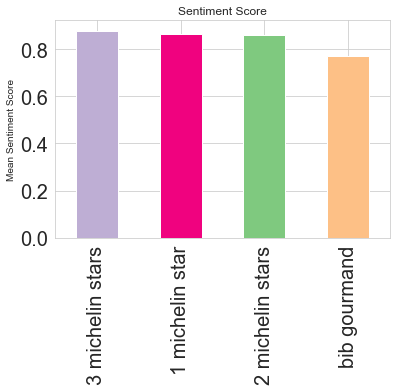

In [56]:
sentiment_scores_bar(train)

In [66]:
def sentiment_country(train):   
    dfg = train.groupby(['country'])['sentiment'].mean().sort_values(ascending= False)
    #create a bar plot
    dfg.plot(kind='bar', title='Sentiment Score', ylabel='Mean Sentiment Score',
         xlabel='',fontsize =10)

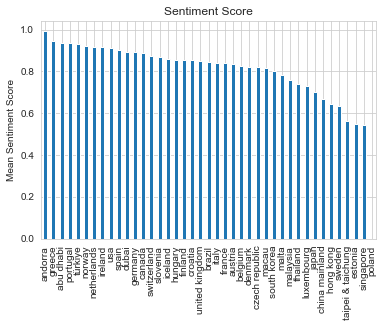

In [67]:
sentiment_country(train)

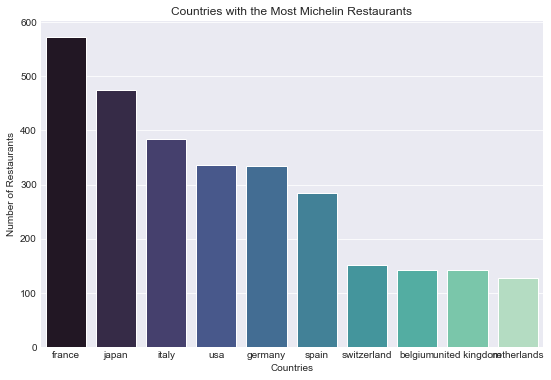

In [ ]:
e.top_10_country_viz(train)

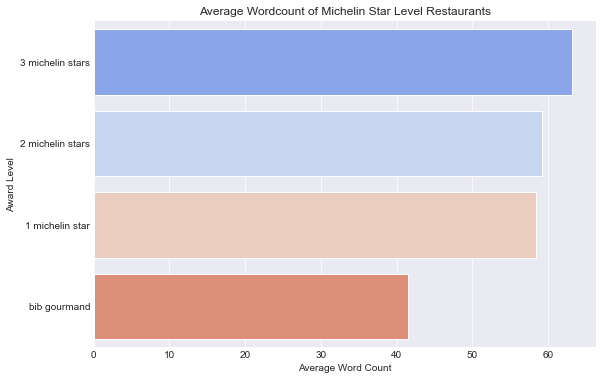

In [ ]:
e.get_wordcount_bar(train)

In [ ]:

def get_clusters(train):    
    X_train_cluster = train[['award', 'sentiment','country']]
    # define cluster object
    kmeans = KMeans(n_clusters=4, random_state = 333)
    # fit cluster object to features
    kmeans.fit(X_train_cluster)
    # use the object
    kmeans.predict(X_train_cluster)


In [77]:
X_train_cluster = train[['award', 'sentiment','country']]

/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:636: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a)
/opt/homebrew/anaconda3/lib/python3.9/site-packages/numpy/ma/core.py:636: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a)


ValueError: shape mismatch: objects cannot be broadcast to a single shape

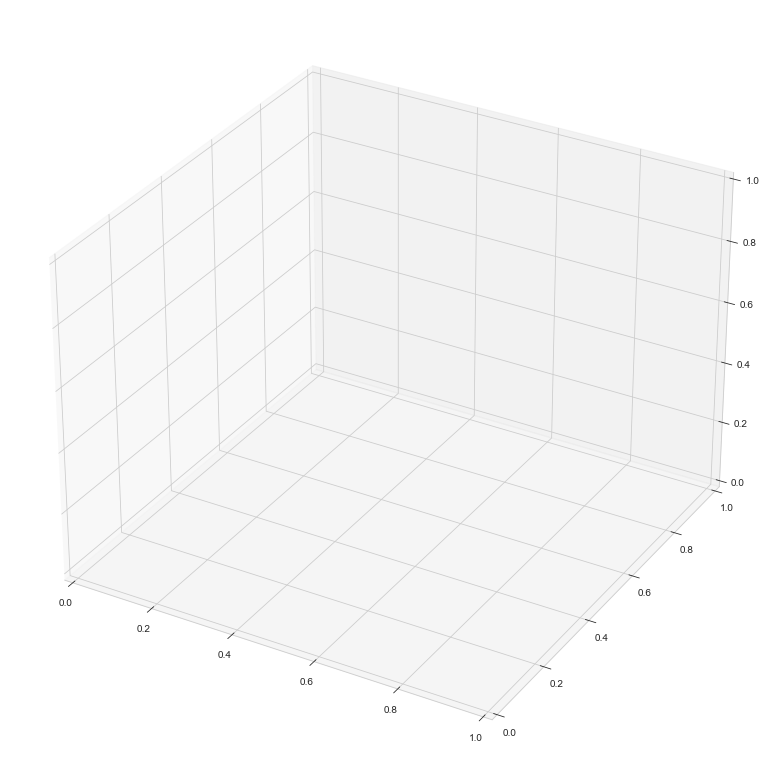

In [78]:
# 3D Clusters
fig = plt.figure(figsize = (14,14))
ax = fig.add_subplot(111, projection = '3d')
x = train.groupby(['award'])
y = train.groupby(['sentiment']).mean()
z = train.groupby(['country'])
ax.scatter(x,y,z, c=X_train_cluster, s = 40, cmap = 'jet')
# ax.legend()
ax.set_xlabel('word_count', fontsize = 15)
ax.set_ylabel('vader',fontsize = 15)
ax.set_zlabel('question_mark_count',fontsize = 15)
plt.title('NPR Clusters by Sentiment, Word Count, and Question Marks')
